In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import tensorflow as tf
import seaborn as sns
import os
from art_track_loader import track_loader as trl
from art_track_features import track_features as trf
from sklearn import svm
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.metrics import f1_score, accuracy_score, roc_curve, precision_recall_curve, PrecisionRecallDisplay, roc_auc_score, plot_roc_curve, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, plot_confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [11]:
train_1 = pd.read_csv(
    'F:/pythonNotebook/art-ms3-art-track-classifier-dataset/KFold_CV/train_1.csv')
train_2 = pd.read_csv(
    'F:/pythonNotebook/art-ms3-art-track-classifier-dataset/KFold_CV/train_2.csv')
train_3 = pd.read_csv(
    'F:/pythonNotebook/art-ms3-art-track-classifier-dataset/KFold_CV/train_3.csv')
train_4 = pd.read_csv(
    'F:/pythonNotebook/art-ms3-art-track-classifier-dataset/KFold_CV/train_4.csv')
train_5 = pd.read_csv(
    'F:/pythonNotebook/art-ms3-art-track-classifier-dataset/KFold_CV/train_5.csv')

val_1 = pd.read_csv(
    'F:/pythonNotebook/art-ms3-art-track-classifier-dataset/KFold_CV/val_1.csv')
val_2 = pd.read_csv(
    'F:/pythonNotebook/art-ms3-art-track-classifier-dataset/KFold_CV/val_2.csv')
val_3 = pd.read_csv(
    'F:/pythonNotebook/art-ms3-art-track-classifier-dataset/KFold_CV/val_3.csv')
val_4 = pd.read_csv(
    'F:/pythonNotebook/art-ms3-art-track-classifier-dataset/KFold_CV/val_4.csv')
val_5 = pd.read_csv(
    'F:/pythonNotebook/art-ms3-art-track-classifier-dataset/KFold_CV/val_5.csv')

In [21]:
FEATURES = np.array([
                    'BestFitDisplacementMean', 'BestFitDisplacementVariance', 'BestFitDiff',
                    'ThetaMean', 'ThetaVariance',
                    'HeightMean', 'HeightVariance',
                    'PowerMean', 'PowerVariance', 'DetectionsMean', 'DetectionsVariance',
                    'VelocityMean', 'VelocityVariance', 'AccelerationMean', 'AccelerationVariance', 'JerkMean', 'JerkVariance',
                    'VelocityXMean', 'VelocityXVariance', 'AccelerationXMean', 'AccelerationXVariance', 'JerkXMean', 'JerkXVariance',
                    'VelocityYMean', 'VelocityYVariance', 'AccelerationYMean', 'AccelerationYVariance', 'JerkYMean', 'JerkYVariance',
                    'VelocityZMean', 'VelocityZVariance', 'AccelerationZMean', 'AccelerationZVariance', 'JerkZMean', 'JerkZVariance'])

In [22]:
FEATURES[17:35]

array(['VelocityXMean', 'VelocityXVariance', 'AccelerationXMean',
       'AccelerationXVariance', 'JerkXMean', 'JerkXVariance',
       'VelocityYMean', 'VelocityYVariance', 'AccelerationYMean',
       'AccelerationYVariance', 'JerkYMean', 'JerkYVariance',
       'VelocityZMean', 'VelocityZVariance', 'AccelerationZMean',
       'AccelerationZVariance', 'JerkZMean', 'JerkZVariance'],
      dtype='<U27')

In [19]:
def select_F(X):
    X = X.loc[:, (
        'BestFitDisplacementMean', 'BestFitDisplacementVariance', 'BestFitDiff',
        'ThetaMean', 'ThetaVariance',
        'HeightMean', 'HeightVariance',
        'PowerMean', 'PowerVariance', 'DetectionsMean', 'DetectionsVariance',
        'VelocityMean', 'VelocityVariance', 'AccelerationMean', 'AccelerationVariance', 'JerkMean', 'JerkVariance',
        'VelocityXMean', 'VelocityXVariance', 'AccelerationXMean', 'AccelerationXVariance', 'JerkXMean', 'JerkXVariance',
        'VelocityYMean', 'VelocityYVariance', 'AccelerationYMean', 'AccelerationYVariance', 'JerkYMean', 'JerkYVariance',
        'VelocityZMean', 'VelocityZVariance', 'AccelerationZMean', 'AccelerationZVariance', 'JerkZMean', 'JerkZVariance'
    )]
    return X


def calculate_all_features(tracks_df, window_size):
    track_series = trl.group_tracks(tracks_df)
    track_series = trf.calculate_and_include_all_features(
        track_series, window_size)
    visualisation_df = pd.concat(track_series.tolist())
    visualisation_df = visualisation_df.dropna()
    features = visualisation_df.loc[:,
                                    'ScenarioTimeStamp':'ThetaVariance']
    labels = visualisation_df['Classification']
    return features, labels


def data_processing(X, y):
    enc = OneHotEncoder()
    enc.fit(y)
    Labels = enc.transform(y).toarray()
    lllbabels = np.argmax(Labels, 1)

    scaler = MinMaxScaler()
#     scaler = StandardScaler()
    features_scaled = scaler.fit_transform(X)
    return features_scaled, Labels


def pre_processing(orinal_data, window_size_max):
    for i in range(3, window_size_max+1):
        feature, label = calculate_all_features(orinal_data, i)
        feature = select_F(feature)

        feature.to_csv(
            'F:/pythonNotebook/art-ms3-art-track-classifier-dataset/KFold_CV/MinMaxscaler/w{i}/features_train_1.csv'.format(i=i))
        label.to_csv(
            'F:/pythonNotebook/art-ms3-art-track-classifier-dataset/KFold_CV/MinMaxscaler/w{i}/label_train_1.csv'.format(i=i))
        feature_scaled, Labels = data_processing(
            feature, np.array(label).reshape(-1, 1))
        os.chdir(
            r'F:/pythonNotebook/art-ms3-art-track-classifier-dataset/KFold_CV/MinMaxscaler/')
        path = './w{i}/'.format(i=i)
        if(os.path.exists(path) == False):  # If not exists, create a new folder
            os.makedirs(path)
        np.save('w{i}/feature_scaled_train_1.npy'.format(i=i), feature_scaled)
        np.save('w{i}/Labels_train_1.npy'.format(i=i), Labels)


pre_processing(train_1, 20)  # Calculate all sets from 3 to 20 sliding windows.

# Check Gaussian distribution


In [13]:
j, i = 14, 3
os.chdir(
    r'F:/pythonNotebook/art-ms3-art-track-classifier-dataset/KFold_CV/')
dis = np.load('w{j}/feature_scaled_train_{i}.npy'.format(j=j, i=i))
feature = pd.read_csv('w{j}/features_train_{i}.csv'.format(j=j, i=i))
for k in range(11, 35):
#     plt.figure(2*(k-11)+1)
#     plt.xlabel(FEATURES[k])
#     plt.plot(dis[:, k])
    plt.figure(2*(k-11)+1)
    plt.xlabel(FEATURES[k])
    plt.hist(dis[:, k], bins=2000,density=True)

# SVM MinMaxscaler

In [ ]:
F1_result = []
os.chdir(
    r'F:/pythonNotebook/art-ms3-art-track-classifier-dataset/KFold_CV/MinMaxscaler/')
for j in range(3, 21):
    F1_macro = []
    for i in range(1, 6):
        X_train = np.load('w{j}/feature_scaled_train_{i}.npy'.format(j=j, i=i))
        y_train = np.load('w{j}/Labels_train_{i}.npy'.format(j=j, i=i))
        X_val = np.load('w{j}/feature_scaled_val_{i}.npy'.format(j=j, i=i))
        y_val = np.load('w{j}/Labels_val_{i}.npy'.format(j=j, i=i))
                                                                                            
        clf = svm.SVC()
        X_train = X_train[:,17:35] #
        X_val = X_val[:,17:35]
        y_train = np.argmax(y_train, 1)
        clf.fit(X_train, y_train)
        y_prediction = clf.predict(X_val)
#         y_prediction = np.argmax(y_prediction, 1)
        y_val = np.argmax(y_val, 1)
        F1_macro.append(f1_score(y_val, y_prediction, average='macro'))
        print(F1_macro[i-1])
    F1_result.append(np.mean(F1_macro))
    print('The F1 score with sliding window as', j, 'is %.4f' % F1_result[j-3])

# XGBoostClassifier

In [ ]:
# model = XGBClassifier()
# grid = dict()
# grid['n_estimators'] = [10, 50, 100, 500]
# grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
# # grid['max_depth'] = [1, 2, 3, 4, 5]
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1)
# # define the grid search procedure
# grid_search = GridSearchCV(
#     estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='f1_macro')
# # execute the grid search
# grid_result = grid_search.fit(X_train, y_train)
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# # summarize all scores that were evaluated
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

os.chdir(r'F:/pythonNotebook/art-ms3-art-track-classifier-dataset/KFold_CV/')
F1_result = []
for j in range(3, 21):
    F1_macro = []
    for i in range(1, 4):
        X_train = np.load('w{j}/feature_scaled_train_{i}.npy'.format(j=j, i=i))
        y_train = np.load('w{j}/Labels_train_{i}.npy'.format(j=j, i=i))
        X_val = np.load('w{j}/feature_scaled_val_{i}.npy'.format(j=j, i=i))
        y_val = np.load('w{j}/Labels_val_{i}.npy'.format(j=j, i=i))
        clf = XGBClassifier()
        X_train = X_train[:,17:35]
        X_val = X_val[:,17:35]
#         X_train = np.concatenate(X_train[11:], axis=1)
#         X_val = np.concatenate(X_val[11:], axis=1)
        clf.fit(X_train, y_train)
        y_prediction = clf.predict(X_val)
        y_prediction = np.argmax(y_prediction, 1)
        y_val = np.argmax(y_val, 1)
        F1_macro.append(f1_score(y_val, y_prediction, average='macro'))
        print(F1_macro[i-1])

#         print('Macro F1 score', F1_macro)
#         confusion_matrix = tf.math.confusion_matrix(y_val, y_prediction, 2)
#         f, ax = plt.subplots(figsize=(5, 5))

#         sns.heatmap(confusion_matrix, annot=True, ax=ax, cmap='Blues', fmt='g')
#         ax.set_title('confusion matrix')
#         ax.set_xlabel('Prediction')
#         ax.set_ylabel('True')
#         plt.xticks(np.arange(2), ['Bird', 'Drone'])
#         plt.yticks(np.arange(2), ['Bird', 'Drone'])
#         # plt.xticks(np.arange(4), ['Bird', 'Drone', 'Pedestrian', 'Vehicle'])
#         # plt.yticks(np.arange(4), ['Bird', 'Drone', 'Pedestrian', 'Vehicle'])
#         plt.show()
    F1_result.append(np.mean(F1_macro))
    print('The F1 score with sliding window as', j, 'is %.4f' % F1_result[j-3])

In [ ]:
from matplotlib.pyplot import MultipleLocator
F1_result_XGB = np.copy(F1_result)
t = range(3,21)
plt.plot(t,F1_result_XGB)
plt.grid()
plt.title('Macro F1 score with sliding windows in XGBoostClassifier')
plt.xlabel('Timestep')
plt.ylabel('Score')
ax=plt.gca()
x_major_locator=MultipleLocator(1)# Set the scale interval of the x-axis to 1
ax.xaxis.set_major_locator(x_major_locator)

Macro F1 score 0.7099426400151407


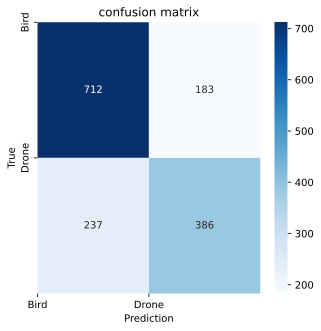

Macro F1 score 0.5614605483751748


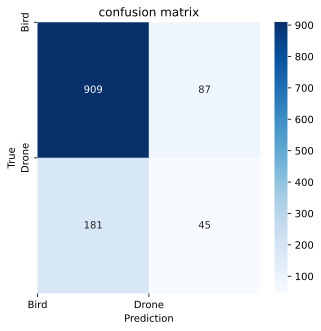

Macro F1 score 0.8474814572375549


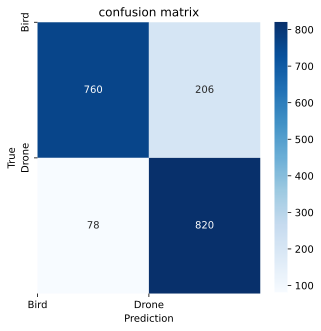

Macro F1 score 0.4179246676614124


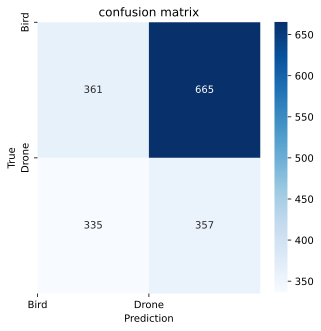

Macro F1 score 0.7388952074262962


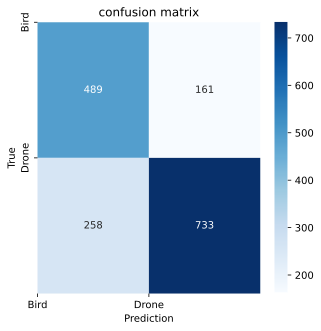

In [8]:
os.chdir(r'F:/pythonNotebook/art-ms3-art-track-classifier-dataset/KFold_CV/')
for i in range(1, 6):
    X_train = np.load('w15/feature_scaled_train_{i}.npy'.format(i=i))
    y_train = np.load('w15/Labels_train_{i}.npy'.format(i=i))
    X_test = np.load('w15/feature_scaled_test_{i}.npy'.format(i=i))
    y_test = np.load('w15/Labels_test_{i}.npy'.format(i=i))
    clf = XGBClassifier()
    clf.fit(X_train, y_train)
    y_prediction = clf.predict(X_test)
    y_prediction = np.argmax(y_prediction, 1)
    y_test = np.argmax(y_test, 1)
    F1_macro = f1_score(y_test, y_prediction, average='macro')

    print('Macro F1 score', F1_macro)
    confusion_matrix = tf.math.confusion_matrix(y_test, y_prediction, 2)
    f, ax = plt.subplots(figsize=(5, 5))

    sns.heatmap(confusion_matrix, annot=True, ax=ax, cmap='Blues', fmt='g')
    ax.set_title('confusion matrix')
    ax.set_xlabel('Prediction')
    ax.set_ylabel('True')
    plt.xticks(np.arange(2), ['Bird', 'Drone'])
    plt.yticks(np.arange(2), ['Bird', 'Drone'])
    # plt.xticks(np.arange(4), ['Bird', 'Drone', 'Pedestrian', 'Vehicle'])
    # plt.yticks(np.arange(4), ['Bird', 'Drone', 'Pedestrian', 'Vehicle'])
    # plt.savefig('F:/pythonNotebook/10_12_18/window_features/confusion/3/19.jpg')
    plt.show()

# RandomForestClassifier

In [25]:
F1_result = []
for j in range(3, 21):
    F1_macro = []
    for i in range(1, 6):
        X_train = np.load('w{j}/feature_scaled_train_{i}.npy'.format(j=j, i=i))
        y_train = np.load('w{j}/Labels_train_{i}.npy'.format(j=j, i=i))
        X_test = np.load('w{j}/feature_scaled_test_{i}.npy'.format(j=j, i=i))
        y_test = np.load('w{j}/Labels_test_{i}.npy'.format(j=j, i=i))
        clf = RandomForestClassifier(n_jobs=-1)
        clf.fit(X_train, y_train)
        y_prediction = clf.predict(X_test)
        y_prediction = np.argmax(y_prediction, 1)
        y_test = np.argmax(y_test, 1)
        F1_macro.append(f1_score(y_test, y_prediction, average='macro'))
    F1_result.append(np.mean(F1_macro))
    print('The F1 score with sliding window as', j, 'is %.4f' % F1_result[j-3])

The F1 score with sliding window as 3 is 0.5202
The F1 score with sliding window as 4 is 0.5048
The F1 score with sliding window as 5 is 0.4810
The F1 score with sliding window as 6 is 0.4508
The F1 score with sliding window as 7 is 0.4348
The F1 score with sliding window as 8 is 0.4538
The F1 score with sliding window as 9 is 0.4801
The F1 score with sliding window as 10 is 0.5167
The F1 score with sliding window as 11 is 0.5512
The F1 score with sliding window as 12 is 0.6074
The F1 score with sliding window as 13 is 0.5892
The F1 score with sliding window as 14 is 0.5483
The F1 score with sliding window as 15 is 0.5520
The F1 score with sliding window as 16 is 0.5539
The F1 score with sliding window as 17 is 0.5420
The F1 score with sliding window as 18 is 0.5425
The F1 score with sliding window as 19 is 0.5572
The F1 score with sliding window as 20 is 0.5485


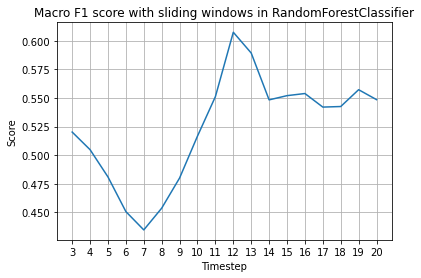

In [26]:
from matplotlib.pyplot import MultipleLocator
F1_result_RF = np.copy(F1_result)
t = range(3,21)
plt.plot(t,F1_result_RF)
plt.grid()
plt.title('Macro F1 score with sliding windows in RandomForestClassifier')
plt.xlabel('Timestep')
plt.ylabel('Score')
ax=plt.gca()
x_major_locator=MultipleLocator(1)# Set the scale interval of the x-axis to 1
ax.xaxis.set_major_locator(x_major_locator)


# GradientBoostingClassifier

In [27]:
F1_result = []
for j in range(3, 21):
    F1_macro = []
    for i in range(1, 6):
        X_train = np.load('w{j}/feature_scaled_train_{i}.npy'.format(j=j, i=i))
        y_train = np.load('w{j}/Labels_train_{i}.npy'.format(j=j, i=i))
        y_train = np.argmax(y_train, 1)        
        X_test = np.load('w{j}/feature_scaled_test_{i}.npy'.format(j=j, i=i))
        y_test = np.load('w{j}/Labels_test_{i}.npy'.format(j=j, i=i))        
        clf = GradientBoostingClassifier()
        clf.fit(X_train, y_train)
        y_prediction = clf.predict(X_test)
#         y_prediction = np.argmax(y_prediction, 1)
        y_test = np.argmax(y_test, 1)
        F1_macro.append(f1_score(y_test, y_prediction, average='macro'))
    F1_result.append(np.mean(F1_macro))
    print('The F1 score with sliding window as', j, 'is %.4f' % F1_result[j-3])

The F1 score with sliding window as 3 is 0.4677
The F1 score with sliding window as 4 is 0.4946
The F1 score with sliding window as 5 is 0.5241
The F1 score with sliding window as 6 is 0.5334
The F1 score with sliding window as 7 is 0.5293
The F1 score with sliding window as 8 is 0.5419
The F1 score with sliding window as 9 is 0.5084
The F1 score with sliding window as 10 is 0.5085
The F1 score with sliding window as 11 is 0.5293
The F1 score with sliding window as 12 is 0.5580
The F1 score with sliding window as 13 is 0.5865
The F1 score with sliding window as 14 is 0.5866
The F1 score with sliding window as 15 is 0.5862
The F1 score with sliding window as 16 is 0.5882
The F1 score with sliding window as 17 is 0.5907
The F1 score with sliding window as 18 is 0.6031
The F1 score with sliding window as 19 is 0.5814
The F1 score with sliding window as 20 is 0.5883


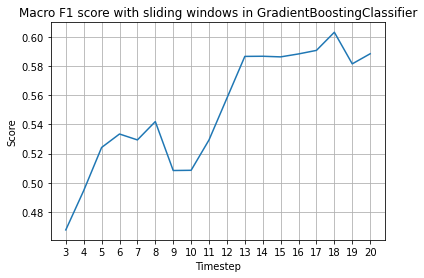

In [28]:
from matplotlib.pyplot import MultipleLocator
F1_result_GDBT = np.copy(F1_result)
t = range(3,21)
plt.plot(t,F1_result_GDBT)
plt.grid()
plt.title('Macro F1 score with sliding windows in GradientBoostingClassifier')
plt.xlabel('Timestep')
plt.ylabel('Score')
ax=plt.gca()
x_major_locator=MultipleLocator(1)# Set the scale interval of the x-axis to 1
ax.xaxis.set_major_locator(x_major_locator)


# AdaBoostClassifier

In [29]:
F1_result = []
for j in range(3, 21):
    F1_macro = []
    for i in range(1, 6):
        X_train = np.load('w{j}/feature_scaled_train_{i}.npy'.format(j=j, i=i))
        y_train = np.load('w{j}/Labels_train_{i}.npy'.format(j=j, i=i))
        y_train = np.argmax(y_train, 1)
        X_test = np.load('w{j}/feature_scaled_test_{i}.npy'.format(j=j, i=i))
        y_test = np.load('w{j}/Labels_test_{i}.npy'.format(j=j, i=i))
        clf = AdaBoostClassifier()
        clf.fit(X_train, y_train)
        y_prediction = clf.predict(X_test)
#         y_prediction = np.argmax(y_prediction, 1)
        y_test = np.argmax(y_test, 1)
        F1_macro.append(f1_score(y_test, y_prediction, average='macro'))
    F1_result.append(np.mean(F1_macro))
    print('The F1 score with sliding window as', j, 'is %.4f' % F1_result[j-3])

The F1 score with sliding window as 3 is 0.5473
The F1 score with sliding window as 4 is 0.5317
The F1 score with sliding window as 5 is 0.5199
The F1 score with sliding window as 6 is 0.4963
The F1 score with sliding window as 7 is 0.5649
The F1 score with sliding window as 8 is 0.5033
The F1 score with sliding window as 9 is 0.4947
The F1 score with sliding window as 10 is 0.5284
The F1 score with sliding window as 11 is 0.5280
The F1 score with sliding window as 12 is 0.5477
The F1 score with sliding window as 13 is 0.5734
The F1 score with sliding window as 14 is 0.6085
The F1 score with sliding window as 15 is 0.5954
The F1 score with sliding window as 16 is 0.5372
The F1 score with sliding window as 17 is 0.5765
The F1 score with sliding window as 18 is 0.5740
The F1 score with sliding window as 19 is 0.5435
The F1 score with sliding window as 20 is 0.5660


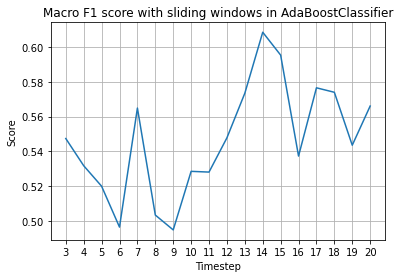

In [30]:
from matplotlib.pyplot import MultipleLocator
F1_result_Ada = np.copy(F1_result)
t = range(3,21)
plt.plot(t,F1_result_Ada)
plt.grid()
plt.title('Macro F1 score with sliding windows in AdaBoostClassifier')
plt.xlabel('Timestep')
plt.ylabel('Score')
ax=plt.gca()
x_major_locator=MultipleLocator(1)# Set the scale interval of the x-axis to 1
ax.xaxis.set_major_locator(x_major_locator)

# NN

In [269]:
from tensorflow import keras
def get_NNmodels(num_feature):
    ########           1           ########
    # inputs = keras.Input(shape=(num_feature, ))
    # x = layers.Dense(64, activation='relu')(inputs)
    # outputs = layers.Dense(4, activation='softmax')(x)

    # model = keras.Model(inputs=inputs, outputs=outputs)
    # model.summary()

    ########           2           ########
    # model = keras.models.Sequential()
    # model.add(keras.layers.InputLayer(input_shape=(num_feature,)))
    # model.add(keras.layers.Dense(64, activation='relu'))
    # model.add(keras.layers.Dense(4, activation='softmax'))

    ########           3           ########
    model = keras.models.Sequential([
        #         keras.layers.InputLayer(input_shape=(25,)),
        #         keras.layers.Dense(448, activation='relu'),

#         keras.layers.LSTM(50, return_sequences=False,
#                           input_shape=(timestep, num_feature)),
#         keras.layers.Dropout(0.5),
#         keras.layers.LSTM(256,return_sequences=False),
#         keras.layers.Dropout(0.5),
#          keras.layers.LSTM(256),
        keras.layers.Dense(32, input_shape=(num_feature,), activation='relu'),
        keras.layers.Dense(2, activation='sigmoid')
        #         keras.layers.Dense(4, activation='softmax')
    ])
#     model.summary()
    return model
# model.compile
# model.fit
# model.evaluate


def compile_fit(model, X_train, y_train, X_val, y_val, n):
    #     optimizer = keras.optimizers.Adam(learning_rate=0.0019526565349868704)
    optimizer = keras.optimizers.Adam()
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer, metrics='accuracy')  # binary_crossentropy/categorical_crossentropy
    history = model.fit(X_train, y_train, epochs=n, verbose=0,
                        validation_data=(X_val, y_val))
    return history

In [283]:
F1_result = []
for j in range(3, 21):
    F1_macro = []
    for i in range(1, 6):
        print('i=', i, 'j=', j, flush=True,end='\r')
        X_train = np.load('w{j}/feature_scaled_train_{i}.npy'.format(j=j, i=i))
        y_train = np.load('w{j}/Labels_train_{i}.npy'.format(j=j, i=i))
#         y_train = np.argmax(y_train, 1)
        X_test = np.load('w{j}/feature_scaled_test_{i}.npy'.format(j=j, i=i))
        y_test = np.load('w{j}/Labels_test_{i}.npy'.format(j=j, i=i))
        X_val = np.load('w{j}/feature_scaled_val_{i}.npy'.format(j=j, i=i))
        y_val = np.load('w{j}/Labels_val_{i}.npy'.format(j=j, i=i))
        model = get_NNmodels(X_train.shape[1])
        history = compile_fit(model, X_train, y_train, X_val, y_val, 50)
        y_prediction = model.predict(X_test)
        prediction_arr = tf.argmax(y_prediction, axis=1)
        labels_arr = tf.argmax(y_test, axis=1)
#         F1_weighted = f1_score(labels_arr, prediction_arr, average='weighted')
        F1_macro.append(f1_score(labels_arr, prediction_arr, average='macro'))

    F1_result.append(np.mean(F1_macro))
    print('The F1 score with sliding window as', j, 'is %.4f' % F1_result[j-3])

The F1 score with sliding window as 3 is 0.5245
The F1 score with sliding window as 4 is 0.5437
The F1 score with sliding window as 5 is 0.5355
The F1 score with sliding window as 6 is 0.5389
The F1 score with sliding window as 7 is 0.5615
The F1 score with sliding window as 8 is 0.5751
The F1 score with sliding window as 9 is 0.5668
The F1 score with sliding window as 10 is 0.5707
The F1 score with sliding window as 11 is 0.5655
The F1 score with sliding window as 12 is 0.5844
The F1 score with sliding window as 13 is 0.5745
The F1 score with sliding window as 14 is 0.5865
The F1 score with sliding window as 15 is 0.5661
The F1 score with sliding window as 16 is 0.5576
The F1 score with sliding window as 17 is 0.5731
The F1 score with sliding window as 18 is 0.5596
The F1 score with sliding window as 19 is 0.5765
The F1 score with sliding window as 20 is 0.5709


# Result

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from matplotlib.pyplot import MultipleLocator
t = range(3,21)
plt.figure(figsize=(8,6))
plt.plot(t,F1_result_Ada,ls='--',marker='*',label='AdaClassifier')
plt.plot(t,F1_result_GDBT,ls='-.',marker ='+',label='GradientBoostClassifier')
plt.plot(t,F1_result_RF,ls=':',marker = 'v',label='RandomForestClassifier')
plt.plot(t,F1_result_XGB,marker = '^',label='XGBoostClassifier')
plt.legend()
plt.grid()
plt.title('Macro F1 score with sliding windows in different classifiers')
plt.xlabel('Sliding window')
plt.ylabel('Score')
ax=plt.gca()
x_major_locator=MultipleLocator(1)# Set the scale interval of the x-axis to 1
ax.xaxis.set_major_locator(x_major_locator)
# plt.savefig('F:/pythonNotebook/11_17_23/F1_line.svg')

In [39]:
np.reshape(F1_result_XGB,(-1,1))

array([[0.48957203],
       [0.50129625],
       [0.51416922],
       [0.51948719],
       [0.53245759],
       [0.48031501],
       [0.5157505 ],
       [0.49623674],
       [0.56948389],
       [0.59166082],
       [0.61339674],
       [0.62106101],
       [0.6551409 ],
       [0.65502517],
       [0.61049217],
       [0.57054537],
       [0.56061221],
       [0.51018029]])